In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [13]:
from helpers import load_data

path_dataset = "../Data/data_train.csv"
ratings = load_data(path_dataset).T
print("Real number of items: {}, Real number of users: {}.".format(
        ratings.shape[0],ratings.shape[1]))
print(ratings.nonzero()[0].size)

number of items: 10000, number of users: 1000
Real number of items: 1000, Real number of users: 10000.
1176952


### Plot the number of ratings per movie and user

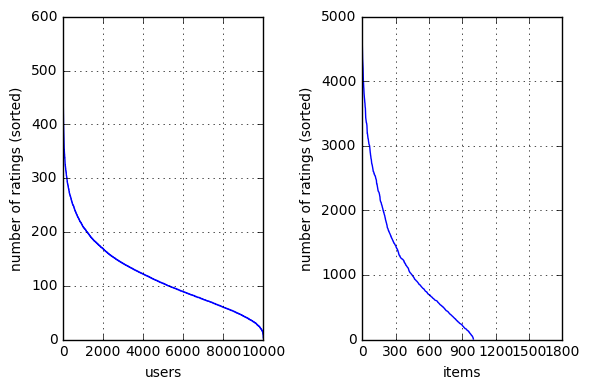

min # of items per user = 3, min # of users per item = 8.


In [14]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [15]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        ratings:
            The given loaded data that corresponds to the ratings of shape (num_items, num_users)
        num_users_per_item:
            Number of users corresponding to every items. shape = (num_items,)
        num_items_per_user:
            Number of items corresponding to every users. shape = (num_users,)
        p_test:
            Probability that one rating is in the test data
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    Returns:
        valid_ratings:
            Ratings that corresponds to the conditions
        train:
            The splitted train data
        test:
            The splitted test data
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]
    
    # initialization
    p_test = 0.1
    train = valid_ratings.copy()
    test = valid_ratings.copy()
    
    # split the data and return train and test data.
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    for u in range(valid_ratings.shape[1]):
        non_zero_ratings = valid_ratings[:, u].nonzero()
        mask_test = np.random.choice(2, non_zero_ratings[0].shape, p=[1-p_test, p_test]).astype(bool)
        test_idxs = non_zero_ratings[0][mask_test]
        train_idxs = non_zero_ratings[0][~mask_test]
        train[test_idxs, u] = 0
        test[train_idxs, u] = 0
    
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:128863
Total number of nonzero elements in test data:14221


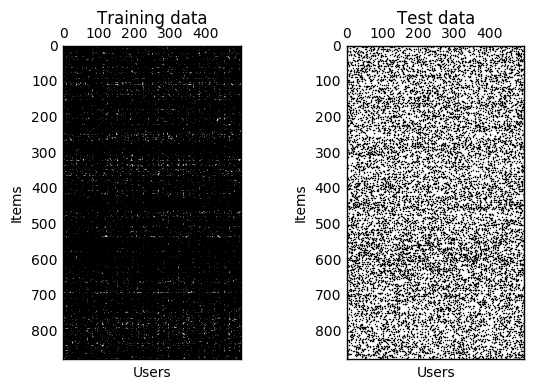

In [16]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=250, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [17]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean.
    Args:
        train:
            Train data array of shape (num_items, num_users)
        test:
            Test data array of shape (num_items, num_users)
    Returns:
        global_mean
        RMSE of training data
        RMSE of test data
    """
    # Compute the global mean
    global_mean = train.sum()/train.nnz
    
    # Compute the RMSE
    tst_nz_indices = test.nonzero()
    mse_test = 1/test.nnz * calculate_mse(test[tst_nz_indices].toarray()[0], global_mean)
    tr_nz_indices = train.nonzero()
    mse_train = 1/train.nnz * calculate_mse(train[tr_nz_indices].toarray()[0], global_mean)
    return global_mean, np.sqrt(mse_train), np.sqrt(mse_test)

baseline_global_mean(train, test)

(4.0069764012943976, 1.1642958524668694, 1.1641932937904456)

### Use the user means as the prediction

In [18]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction.
    Args:
        train:
            Train data array of shape (num_items, num_users)
        test:
            Test data array of shape (num_items, num_users)
    Returns:
        means:
            Array of user's means. shape = (num_users,)
        RMSE of training data
        RMSE of test data
    """
    # Compute mean for every users
    means = np.array(train.sum(axis=0)/train.getnnz(axis=0))[0]
    
    # Compute the RMSE
    tst_nz_idx = test.nonzero()
    mse_test = 1/len(tst_nz_idx[1]) * calculate_mse(test[tst_nz_idx].toarray()[0], means[tst_nz_idx[1]])
    tr_nz_idx = train.nonzero()
    mse_train = 1/len(tr_nz_idx[1]) * calculate_mse(train[tr_nz_idx].toarray()[0], means[tr_nz_idx[1]])
    return means, np.sqrt(mse_train), np.sqrt(mse_test)

_, rmse_tr, rmse_te = baseline_user_mean(train, test)
print("RMSE on train data: {}. RMSE on test data: {}".format(rmse_tr, rmse_te))

RMSE on train data: 1.1229053240558833. RMSE on test data: 1.1272902078623226


### Use the item means as the prediction

In [19]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction.
    Args:
        train:
            Train data array of shape (num_items, num_users)
        test:
            Test data array of shape (num_items, num_users)
    Returns:
        means:
            Array of item's means. shape = (num_items,)
        RMSE of training data
        RMSE of test data
    """
    # Compute mean for every users
    means = np.array(train.sum(axis=1).T/train.getnnz(axis=1))[0]
    
    # Compute the RMSE
    tst_nz_idx = test.nonzero()
    mse_test = 1/len(tst_nz_idx[0]) * calculate_mse(test[tst_nz_idx].toarray()[0], means[tst_nz_idx[0]])
    tr_nz_idx = train.nonzero()
    mse_train = 1/len(tr_nz_idx[0]) * calculate_mse(train[tr_nz_idx].toarray()[0], means[tr_nz_idx[0]])
    return means, np.sqrt(mse_train), np.sqrt(mse_test)

_, rmse_tr, rmse_te = baseline_item_mean(train, test)
print("RMSE on train data: {}. RMSE on test data: {}".format(rmse_tr, rmse_te))

RMSE on train data: 1.0497593205548639. RMSE on test data: 1.0541952452423178


### Cost function

In [20]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (RMSE) of the prediction of nonzero elements."""
    loss = 0
    #prediction = np.zeros(data.shape)
    nz_data = np.array([data[d,n] for (d,n) in nz])
    prediction = np.array([(np.dot(item_features[:, d].T,(user_features[:,n]))) for (d,n) in nz])
    return np.sqrt(1/len(nz) * calculate_mse(nz_data, prediction))

### Learn the Matrix Factorization using SGD

In [10]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    num_item, num_user = train.shape
    user_features = np.random.randn(num_features, num_user)
    item_features = np.random.randn(num_features, num_item)
    return user_features, item_features

In [31]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    num_item, num_user = train.shape
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):   
        # decrease step size
        gamma /= 1.2
        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # Matrix factorization
        for d, n in nz_train:
            # Calculate Gradient
            error = train[d, n] - (item_features[:, d].T @ user_features[:, n])
            gradient = np.zeros((num_item + num_user, num_features))
            gradient[d, :] = - error * user_features[:, n].T + lambda_item * item_features[:, d].T
            gradient[num_item + n, :] = - error * item_features[:, d].T + lambda_user * user_features[:, n].T
            
            # Update W and Z
            item_features = item_features - gamma*gradient[:num_item,:].T
            user_features = user_features - gamma*gradient[num_item:,:].T
        # Add regularizer
        rmse_train = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse_train))
        
        errors.append(rmse_train)
    # Compute the test error.
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.1648225060570905.
iter: 1, RMSE on training set: 1.063679162469377.
iter: 2, RMSE on training set: 1.049136443976977.
iter: 3, RMSE on training set: 1.0378052080028055.
iter: 4, RMSE on training set: 1.0391744348650818.
iter: 5, RMSE on training set: 1.0343315489422737.
iter: 6, RMSE on training set: 1.033095555234005.
iter: 7, RMSE on training set: 1.0328485115565842.
iter: 8, RMSE on training set: 1.0302825872356067.
iter: 9, RMSE on training set: 1.0303445013338457.
iter: 10, RMSE on training set: 1.0291341725841365.
iter: 11, RMSE on training set: 1.028839422254478.
iter: 12, RMSE on training set: 1.0284361660223649.
iter: 13, RMSE on training set: 1.0279163917407124.
iter: 14, RMSE on training set: 1.0282368401250361.
iter: 15, RMSE on training set: 1.0280889178039383.
iter: 16, RMSE on training set: 1.0281726128376947.
iter: 17, RMSE on training set: 1.028031856526169.
iter: 18, RMSE on training set: 1.0

### Learn the Matrix Factorization using Alternating Least Squares

In [11]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    num_users = train.shape[1]
    K = item_features.shape[0]
    Z = np.zeros((K, num_users))
    
    for n in range(num_users):
        nz_item_features_per_user = item_features[:, nz_user_itemindices[n]]
        A = nz_item_features_per_user @ nz_item_features_per_user.T + nnz_items_per_user[n] * lambda_user*np.eye(K)
        train_per_user_nz_items=train[nz_user_itemindices[n],n] 
        B = nz_item_features_per_user @ train_per_user_nz_items 
        Z[:, n] = np.linalg.solve(A, B)[:,0] 
    return Z

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    num_items = train.shape[0]
    K = user_features.shape[0]
    W = np.zeros((K, num_items))
    
    for d in range(num_items):
        nz_user_features_per_item = user_features[:, nz_item_userindices[d]]
        A = nz_user_features_per_item @ nz_user_features_per_item.T + nnz_users_per_item[d]*lambda_item*np.eye(K)
        train_per_item_nz_users=train[d,nz_item_userindices[d]] 
        B = nz_user_features_per_item @ train_per_item_nz_users.T 
        W[:, d] = np.linalg.solve(A, B)[:,0]
    return W

In [12]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    item_means, _, _ = baseline_item_mean(train, train)
    num_item, num_user = train.shape
    item_features = np.random.randn(num_features, num_item)
    item_features[0,:] = item_means
    user_means, _, _ = baseline_user_mean(train, train)
    user_features = np.random.randn(num_features, num_user)
    user_features[0,:] = user_means
    return user_features, item_features

In [16]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    max_iter = 50
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # Calculate arguments for the update of Z and W
    nnz_items_per_user = train.getnnz(axis=0)
    nnz_users_per_item = train.getnnz(axis=1)
    nz_user_itemindices = []
    nz_item_userindices = []
    nz_train, nz_row_colindices, nz_col_rowindices= build_index_groups(train)

    for row,colindices in nz_row_colindices:
        nz_item_userindices.append(colindices)
    for col,rowindices in nz_col_rowindices:
        nz_user_itemindices.append(rowindices)
    
    for it in range(max_iter):        
        # Fix W. Solve Z
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        # Fix Z. Solve W
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        nz_row, nz_col = train.nonzero()
        nz_train = list(zip(nz_row, nz_col))
        print(compute_error(train, user_features, item_features, nz_train))
    return user_features, item_features
ALS(train, test)

1.9448083943
1.29210863136
1.16333447999
1.11122770734
1.08491302422
1.06986764223
1.06055460626
1.05446946049
1.05033864162
1.04745612902
1.04540369912
1.04392036157
1.04283636826
1.04203762008
1.04144539305
1.04100423875
1.04067446562
1.04042730088
1.04024168209
1.04010207446
1.03999695379
1.03991773314
1.03985799264
1.0398129202
1.03977890186
1.03975321945
1.03973382622
1.03971917976
1.03970811688
1.03969976004
1.03969344689
1.03968867739
1.03968507395
1.03968235142
1.0396802944
1.03967874018
1.03967756585
1.03967667854
1.0396760081
1.03967550152
1.03967511875
1.03967482953
1.03967461099
1.03967444587
1.0396743211
1.03967422682
1.03967415558
1.03967410176
1.03967406109
1.03967403035


(array([[  2.90087670e+00,   2.74641540e+00,   2.91197783e+00, ...,
           2.68883767e+00,   2.90099167e+00,   3.12650651e+00],
        [  9.86386722e-03,   9.33865164e-03,   9.90161449e-03, ...,
           9.14286977e-03,   9.86425819e-03,   1.06310776e-02],
        [ -9.37298315e-03,  -8.87390530e-03,  -9.40885187e-03, ...,
          -8.68786651e-03,  -9.37335454e-03,  -1.01020125e-02],
        ..., 
        [  4.97292733e-05,   4.70817837e-05,   4.99196686e-05, ...,
           4.60956073e-05,   4.97318599e-05,   5.35977305e-05],
        [ -8.37820928e-03,  -7.93209983e-03,  -8.41027124e-03, ...,
          -7.76580624e-03,  -8.37854162e-03,  -9.02986555e-03],
        [  1.08890916e-03,   1.03092868e-03,   1.09307623e-03, ...,
           1.00931567e-03,   1.08895237e-03,   1.17360442e-03]]),
 array([[  1.16052560e+00,   1.16574667e+00,   1.11591891e+00, ...,
           1.17262826e+00,   1.17924304e+00,   1.20455958e+00],
        [  3.94614170e-03,   3.96389493e-03,   3.79446532e-0

## Submission

In [ ]:
def create_submission_csv(predictions,name):
    with open(name, 'w') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for item,user in zip(predictions):
            writer.writerow({'Id': int(r1), 'Prediction': int(r2)})